# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [1]:
#!pip install matplotlib tqdm numpy ipympl opencv-python
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

c:\Users\antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Présentation du problème

In [3]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [4]:
def find_mu_star(MAB):

    max_index = 0
    for i in range(1, len(MAB)):
        if MAB[i].immunity_rate > MAB[max_index].immunity_rate:
            max_index = i
    return MAB[max_index].immunity_rate

mu_star = find_mu_star(MAB)
print(f"La valeur de mu* est: {mu_star}")

La valeur de mu* est: 0.7682217955589294


*Ici la valeur de mu*\* *correspond à la valeur d'efficacité du meilleur vaccin parmi les 5 qui est d'environ 0.768.*

*La récompense Rk appliqué est défini parmi 0 et 1 en fonction de son succès. Pour simuler le vaccin, on tire aléatoirement un float compris entre 0 et 1, s'il est inférieur à l'efficacité théorique du vaccin stockée dans MAB, c'est un succès (Rk = 1), sinon c'est un échec (Rk = 0).*

*Le regret ici représente l'intérêt que l'on porte à un vaccin pour l'appliquer au prochain patient ; plus il est élevé et supérieur aux regrets des autres vaccins, plus on aura l'intention de le selectionner.*

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez le vaccin optimal à l'issue d'une phase d'exploration. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [5]:
K = 5
N = 50
M = 500

In [6]:
MABs = [generate_arms(K) for _ in range(100)]

Nombre de meilleur vaccin trouvé:  68
Regret moyen:  30.894392013549805
Ecart type:  31.458083586722488


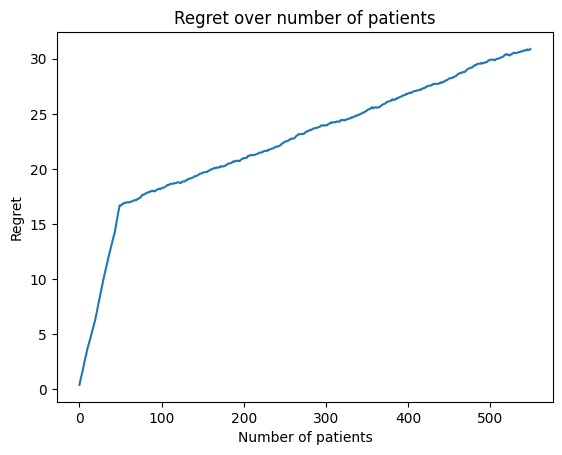

In [7]:
def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm))
    return torch.stack(results)


def calculate_mu_hat(results):
    return results.float().mean(dim=1)

def exploit(mab, mu_hat, m, esperance):
    max_index = 0
    for i in range(1, len(mab)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    if mab[max_index].immunity_rate == find_mu_star(mab):
        esperance +=1
    samples = mab[max_index].sample(m)
    return samples, esperance

def calculate_regret_for_one_MAB(mab, results):
    regret = 0
    regret_list = []
    mu_star = find_mu_star(mab)
    for i in range(len(results)):
        #print(results[i])
        if results[i]:
            regret += mu_star - 1
        else:
            regret += mu_star
        regret_list.append(float(regret))
    return torch.tensor(regret_list)

def get_regret_list(mabs, total_results):
    regrets = []
    for i in range(len(mabs)):
        regret = calculate_regret_for_one_MAB(mabs[i], total_results[i])
        regrets.append(regret)
    return regrets

def check_if_best_arm_is_found(mab, results):
    mu_star = find_mu_star(mab)
    for i in range(len(results)):
        if results[i]:
            return mu_star - 1
    return mu_star

def run_on_MABs(mabs, n, m, esperance):
    total_results = []
    for mab in mabs:
        explore_result = explore(mab, n)
        mu_hat = calculate_mu_hat(explore_result)
        exploit_result, esperance = exploit(mab, mu_hat, m, esperance)
        all_explore_result = torch.cat([explore_result[i] for i in range(K)])
        all_result = torch.cat([all_explore_result, exploit_result])
        total_results.append(all_result)
    regrets = get_regret_list(mabs, total_results)
    return regrets, esperance

esperance = 0
regrets, esperance = run_on_MABs(MABs, N, M, esperance)
mean_regrets = torch.stack(regrets).mean(dim=0)
print("Nombre de meilleur vaccin trouvé: ", esperance)
print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()




*Lors de cette exécution, nous trouvons 68 fois le meilleur vaccin après la phase d'exploration sur les 100 MAB, ce qui nous donne une espérance empirique de trouver le meilleur vaccin à 68%.*

*L'espérance empirique du regret après la vaccination des 550 patients s'élève à 30.89 avec un écart-type mesuré à 31.46 au cours des 100 simulations.*

**Q3. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

In [8]:
N_list = [K*i for i in range(1, M // K + 1)]

Text(0, 0.5, 'Regret')

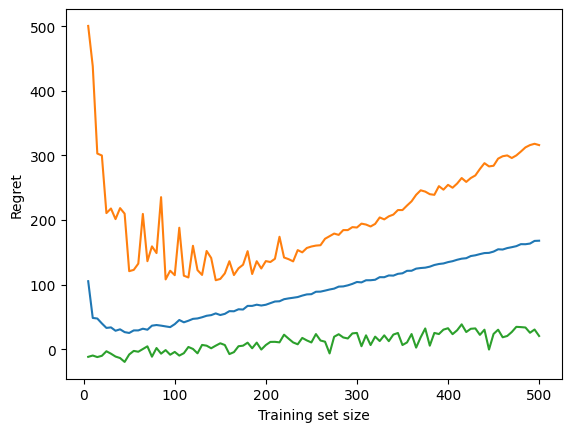

In [9]:
extracted_mean_regrets = []
extracted_max_regrets = []
extracted_min_regrets = []
for i in N_list:
    regrets, esperance = run_on_MABs(MABs, i, M + N - i, esperance)
    mean_regrets = torch.stack(regrets).mean(dim=0)
    mean_regrets_last = mean_regrets[-1]
    max_regrets_last = torch.stack(regrets).max(dim=0).values[-1]
    min_regrets_last = torch.stack(regrets).min(dim=0).values[-1]
    extracted_mean_regrets.append(mean_regrets_last)
    extracted_max_regrets.append(max_regrets_last)
    extracted_min_regrets.append(min_regrets_last)

plt.plot(N_list, extracted_mean_regrets, label='Mean regret')
plt.plot(N_list, extracted_max_regrets, label='Max regret')
plt.plot(N_list, extracted_min_regrets, label='Min regret')
plt.xlabel('Training set size')
plt.ylabel('Regret')


*En faisant varier N entre K et M, on remarque que le regret moyen atteint son minimum à environ 50 patient en phase d'exploration, il s'agit donc de la  taille optimale du traing set, nous pourrons donc conserver N = 50 par la suite.*

**Q4. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\hat{\mu}_i$ pendant la phase d'exploitation (algorithme *greedy*). Concrètement, à chaque nouvel patient, on lui administre le meilleur vaccin selon les stats. Notez vous une amélioration du regret ? Proposez un exemple où les taux d'immunisation du MAB ne changent rien.** 

Regret moyen:  21.474355697631836
Ecart type:  15.04036418879678


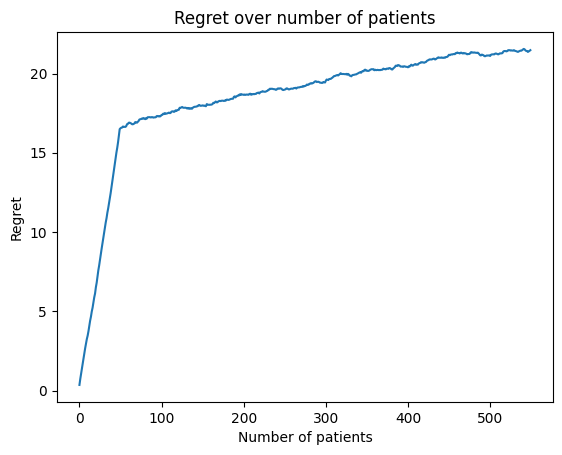

In [10]:
def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    return [result.mean() for result in results]

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):

    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()


*Cette fois-ci, en choisissant toujours le vaccin présentant les meilleures statistiques de succès, on réduit à la fois l'espérance et l'écart-type de du regret, passant empiriquement à 21.47 et 15.04. C'est donc une nette amélioration des résultats.* 

*Dans un cas où durant la phase d'exploration, le meilleur vaccin ne montre pas de résultats suffisants, il aura peu de chance d'être le vaccin avec les meilleures statistiques durant l'exploitation et ne sera donc jamais utilisé. Dans ce cas, cette méthode n'est pas meilleure que la précédente. De même si le meilleur vaccin est excellent durant l'exploration, il aurait aussi été selectionné avec la première méthode.*

**Q5. Nouvelle amélioration : à chaque nouveau patient, on choisit si on lui administre le meilleur vaccin avec une probabilité $\epsilon$ ou un vaccin aléatoire ($p=1-\epsilon$). Vérifiez si vous obtenez un meilleur résultat avec N = 0 ou N > 0. À votre avis, à quoi sert $\epsilon$ ?** 

Regret moyen:  36.654327392578125
Ecart type:  13.96875710028483


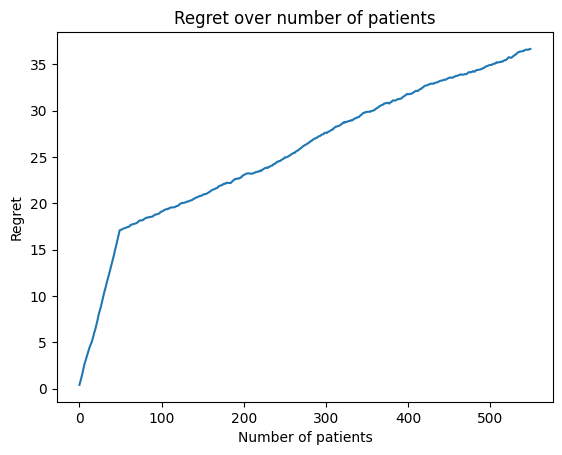

In [11]:
epsilon = 0.9

def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    return [result.mean() for result in results]

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):

    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m, epsilon):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()


*En prenant N = 50 et en choisissant arbitrairement epsilon = 0.9 < 1, on trouve un regret supérieur à la méthode sans epsilon, mais l'écart-type ici est faible*

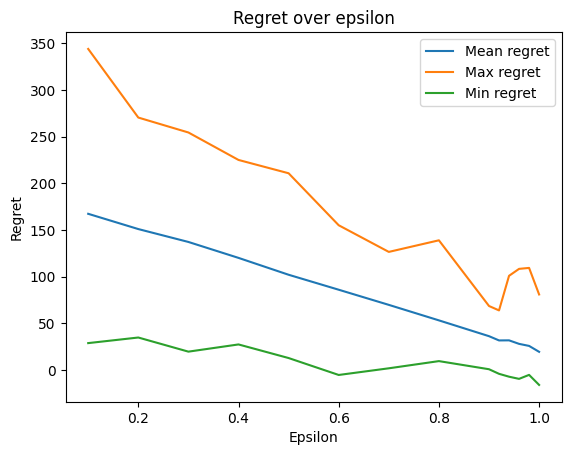

In [12]:
eps_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92 , 0.94, 0.96, 0.98, 1.0]

extracted_mean_regrets = []
extracted_max_regrets = []
extracted_min_regrets = []
for eps in eps_list:
    regrets = run_on_MABs_greedy(MABs, N, M, eps)
    mean_regrets = torch.stack(regrets).mean(dim=0)
    mean_regrets_last = mean_regrets[-1]
    max_regrets_last = torch.stack(regrets).max(dim=0).values[-1]
    min_regrets_last = torch.stack(regrets).min(dim=0).values[-1]
    extracted_mean_regrets.append(mean_regrets_last)
    extracted_max_regrets.append(max_regrets_last)
    extracted_min_regrets.append(min_regrets_last)

plt.plot(eps_list, extracted_mean_regrets, label='Mean regret')
plt.plot(eps_list, extracted_max_regrets, label='Max regret')
plt.plot(eps_list, extracted_min_regrets, label='Min regret')
plt.xlabel('Epsilon')
plt.ylabel('Regret')
plt.title('Regret over epsilon')
plt.legend()
plt.show()




*On remarque qu'avec N = 50, l'ajout d'un epsilon < 1 ne diminue pas le regret moyen. Nous allons faire le test en ignorant la phase d'exploration, N = 0.*

Regret moyen:  34.694366455078125
Ecart type:  24.680077009034534


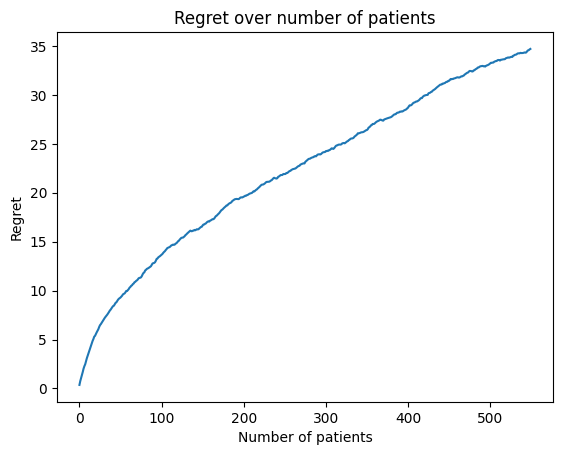

In [13]:
epsilon = 0.90

def calculate_mu_hat(results):
    mu_hat = []
    for result in results:
        if len(result) == 0:
            mu_hat.append(0)
        else:
            mu_hat.append(result.mean())
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):

    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, m, epsilon):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, M + N, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Le retrait de la phase d'exploration n'a pas significativement diminué le regret et en a augmenté son écart-type.

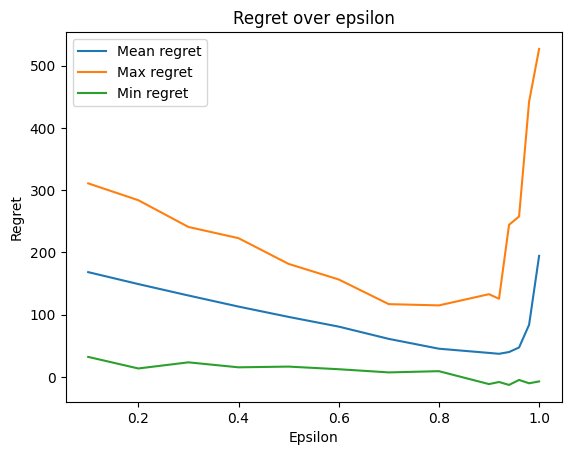

In [14]:
eps_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92 , 0.94, 0.96, 0.98, 1.0]

extracted_mean_regrets = []
extracted_max_regrets = []
extracted_min_regrets = []
for eps in eps_list:
    regrets = run_on_MABs_greedy(MABs, M + N, eps)
    mean_regrets = torch.stack(regrets).mean(dim=0)
    mean_regrets_last = mean_regrets[-1]
    max_regrets_last = torch.stack(regrets).max(dim=0).values[-1]
    min_regrets_last = torch.stack(regrets).min(dim=0).values[-1]
    extracted_mean_regrets.append(mean_regrets_last)
    extracted_max_regrets.append(max_regrets_last)
    extracted_min_regrets.append(min_regrets_last)

plt.plot(eps_list, extracted_mean_regrets, label='Mean regret')
plt.plot(eps_list, extracted_max_regrets, label='Max regret')
plt.plot(eps_list, extracted_min_regrets, label='Min regret')
plt.xlabel('Epsilon')
plt.ylabel('Regret')
plt.title('Regret over epsilon')
plt.legend()
plt.show()

*Cependant dans le cas où N = 0, cette méhode semble plus efficace avec un epsilon < 1. on peut observer une valeur optimale autour de 0.9*
*epsilon permet dans cette méthode de choisir de temps en temps un vaccin qui n'est pas le meilleur pour lui donner une chance de montrer de meilleurs résultats. Celà évite à un bon vaccin de tomber dans l'oubli si ses premiers résultats sont négatifs.*

*En choississant epsilon = 0.9 < 1 dans cette simulation, on trouve des résultats plutôt similaires pour N = 0 et N > 0.*

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

In [15]:
# def explore(mab, n):
#     test_per_arm = n // K
#     results = []
#     for arm in mab:
#         results.append(arm.sample(test_per_arm).float())
#     return results

# def calculate_mu_hat(results):
#     return [result.mean() for result in results]

# def search_best_arm(mu_hat):
#     max_index = 0
#     for i in range(1, len(mu_hat)):
#         if mu_hat[i] > mu_hat[max_index]:
#             max_index = i
#     return max_index

# def exploit(all_results, results, mab, mu_hat, m):

#     for i in range(m):
#         best_arm = search_best_arm(mu_hat)
#         sample = mab[best_arm].sample().float()
#         results[best_arm] = torch.cat([results[best_arm], sample])
#         mu_hat = calculate_mu_hat(results)
#         all_results = torch.cat([all_results, sample])
#     return results, all_results

# def rewards_line(all_results):
#     rewards = [0]
#     for i in range(len(all_results)):
#         if all_results[i]:
#             rewards.append(rewards[-1] + 1)
#         else:
#             rewards.append(rewards[-1])
#     for i in range(len(rewards)):
#         rewards[i] = rewards[i] / math.log(i + 2)
#     return rewards[1:]

    


In [16]:
# def kl_divergence(p, q):
#     return p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))

# def lai_robbins_bound(mu_star, MAB, n):
#     C_mu = sum((mu_star - arm.immunity_rate) / kl_divergence(arm.immunity_rate, mu_star) for arm in MAB if arm.immunity_rate < mu_star)
#     return C_mu 


# LRR_list = []
# regrets_list = []
# all_rewards = []

# for mab in MABs:

#     results = explore(mab, N)
#     all_results = torch.cat([results[i] for i in range(K)])
#     mu_hat = calculate_mu_hat(results)
#     results, all_results = exploit(all_results, results, mab, mu_hat, M)
#     regret = calculate_regret_for_one_MAB(mab, all_results)
#     regrets_list.append(regret)
#     LRR = lai_robbins_bound(mu_star, mab, N + M)
#     LRR_list.append(LRR)
#     all_rewards.append(rewards_line(all_results))

# regrets = torch.stack(regrets_list).mean(dim=0)
# LRR = torch.tensor(LRR_list).mean()
# rewards = torch.tensor(all_rewards).mean(dim=0)




# plt.plot(regrets, label='Regret méthode gloutonne')
# plt.plot(rewards, label='Reward méthode gloutonne')
# plt.axhline(y=LRR.item(), color='r', linestyle='--', label='Lai & Robbins Bound')
# plt.xlabel('Number of patients')
# plt.ylabel('Regret')
# plt.title('Comparison of Regret with Lai & Robbins Bound')
# plt.legend()
# plt.show()



*Mes résultats n'étaient pas cohérents*

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C\log{n}}{T_i}}$,

avec $C=2$.


**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.

Regret moyen:  56.024375915527344
Ecart type:  14.04129803604743


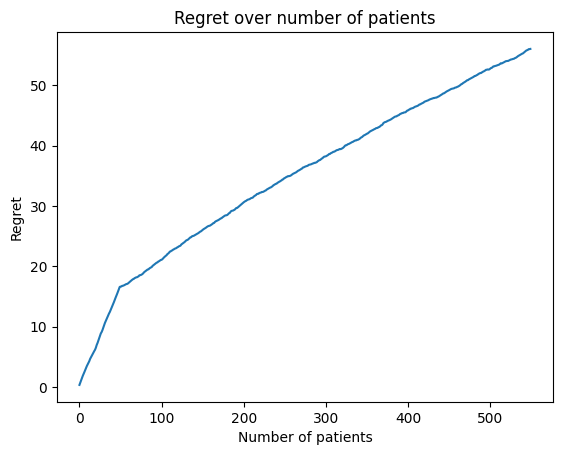

In [17]:
epsilon = 0.9
C = 2

def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):
    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m, epsilon):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()


*Faisons le test en conservant N = 50 et epsilon = 0.9. On trouve un regret à 56 avec un écart-type faible à 14.*

Regret moyen:  54.38438415527344
Ecart type:  13.403395128718786


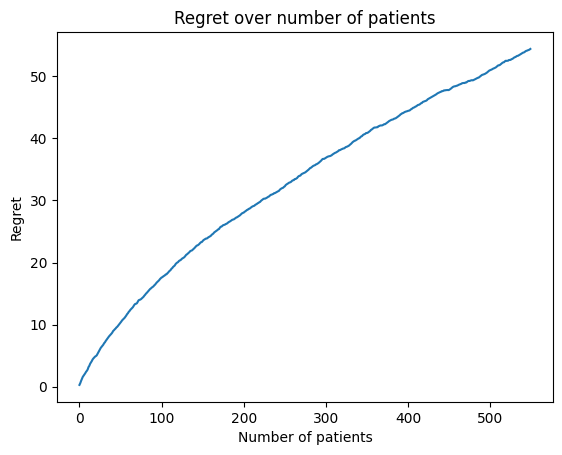

In [18]:
epsilon = 0.90
C = 2

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):
    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, m, epsilon):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, M + N, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*En retirant la phase d'exploration, N = 0, on obtient un regret et son écart-type quasiment et l'asymptote à droite quasiment identiques aussi.*

Regret moyen:  49.25437545776367
Ecart type:  13.062535628128744


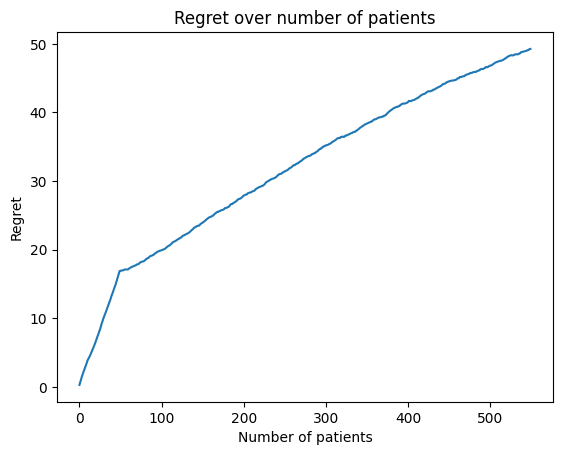

In [19]:

C = 2

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()


*On retrouve à nouveau des résultats similaires en réinstaurant l'exploration et en définissant epsilon = 1.*

Regret moyen:  49.804359436035156
Ecart type:  12.775922565032058


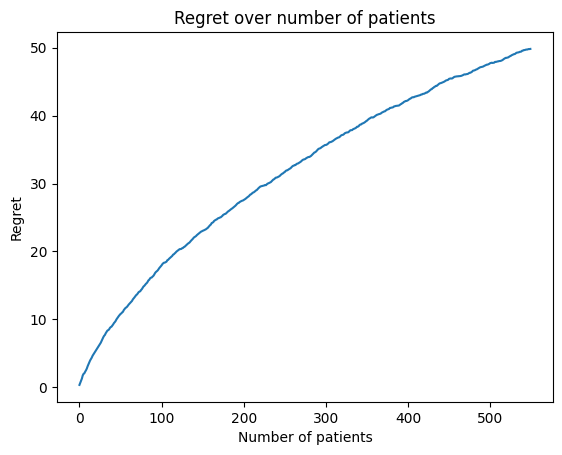

In [20]:
C = 2

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, m):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, M + N)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Et de même ici est fixant epsilon = 1 et N = 0. La méthode UCB ne semble donc ni avoir besoin d'une phase d'exploration, ni d'impliquer un epsilon < 1.*

**Q9. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$ pour chaque vaccin.**

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

Regret moyen:  21.54436492919922
Ecart type:  12.560719226241336


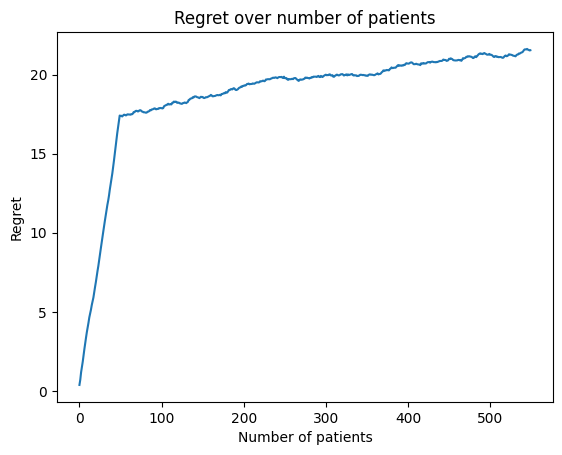

In [21]:
epsilon = 1

def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    return [result.mean() for result in results]

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):

    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m, epsilon):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

Regret moyen:  50.0143928527832
Ecart type:  13.372590320315657


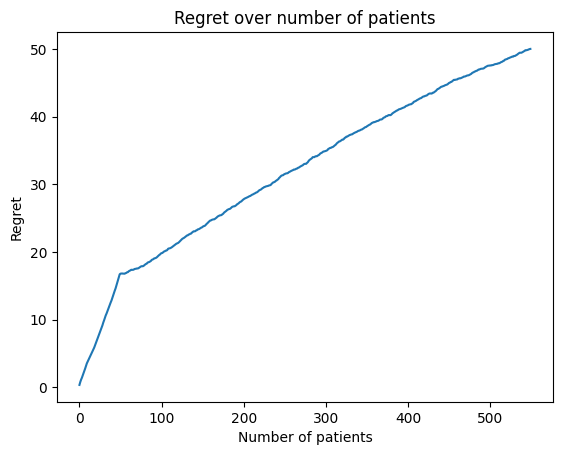

In [22]:
def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

regrets = run_on_MABs_greedy(MABs, N, M, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Avec une phase d'exploration, la méthode gloutonne semble bien plus efficace quant au regret et à son asymptote à droite.*

Regret moyen:  31.294334411621094
Ecart type:  71.10298017004983


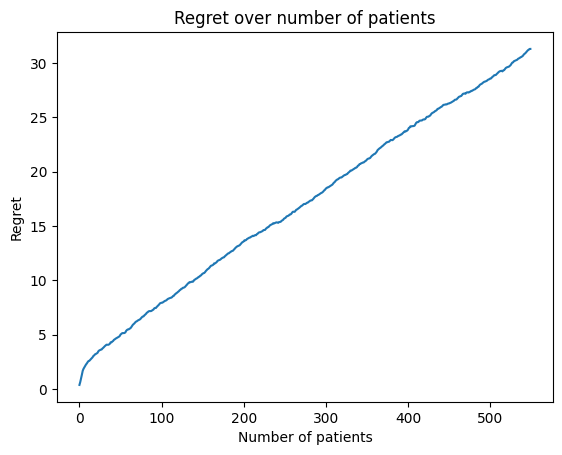

In [23]:
epsilon = 1

def calculate_mu_hat(results):
    mu_hat = []
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean())
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon):

    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, m, epsilon):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, M + N, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*En retirant la phase d'exploration, l'écart-type de la méthode gloutonne semble très élevé ce qui en ferait une méthode risquée.*

Regret moyen:  49.57437515258789
Ecart type:  12.016647870758495


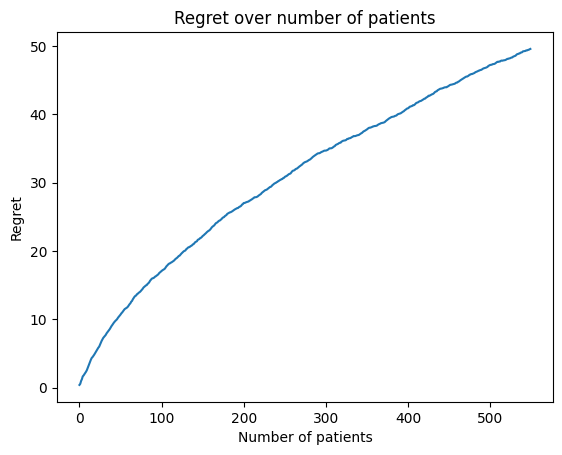

In [24]:
def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

regrets = run_on_MABs_greedy(MABs, M + N, epsilon)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Même si le resultats sur le regret est moins bon pour UCB que pour la méthode gloutonne. l'asymptote à droite semble donner l'avantage au long terme pour l'UCB et son écart-type bien plus faible rend cette méthode plus fiable.* 

*Et en comparant les 2 simulations de l'UCB avec N = 0 et N = 50 on obtient des résultats similaires. Ainsi, N > 0 est inutile pour la méthode UCB.*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

In [25]:
epsilon = 1

def calculate_mu_hat(results, c):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(c * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon, c):

    for i in range(m):
        if torch.rand(1) < epsilon:
            best_arm = search_best_arm(mu_hat)
        else:
            best_arm = torch.randint(0, K, (1,))
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results, c)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, m, epsilon, c):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results, c)
        results, all_results = exploit_epsilon(all_results, results, mab, mu_hat, m, epsilon, c)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

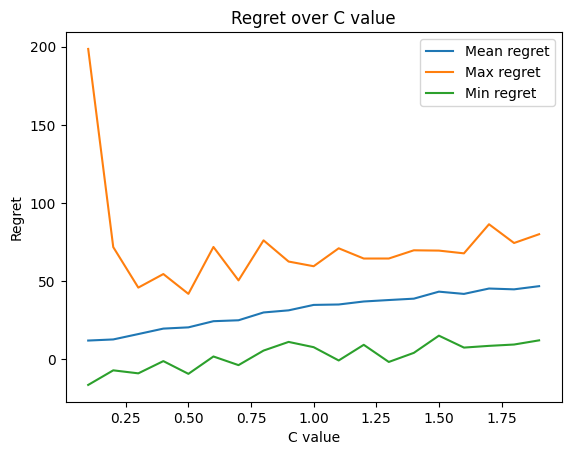

In [26]:
C_list = [0 + 0.1 * i for i in range(1, 20)]
epsilon = 1

extracted_mean_regrets = []
extracted_max_regrets = []
extracted_min_regrets = []
for c in C_list:
    regrets = run_on_MABs_greedy(MABs, M + N, epsilon, c)
    mean_regrets = torch.stack(regrets).mean(dim=0)
    mean_regrets_last = mean_regrets[-1]
    max_regrets_last = torch.stack(regrets).max(dim=0).values[-1]
    min_regrets_last = torch.stack(regrets).min(dim=0).values[-1]
    extracted_mean_regrets.append(mean_regrets_last)
    extracted_max_regrets.append(max_regrets_last)
    extracted_min_regrets.append(min_regrets_last)

plt.plot(C_list, extracted_mean_regrets, label='Mean regret')
plt.plot(C_list, extracted_max_regrets, label='Max regret')
plt.plot(C_list, extracted_min_regrets, label='Min regret')
plt.xlabel('C value')
plt.ylabel('Regret')
plt.title('Regret over C value')
plt.legend()
plt.show()

*Les résultats obtenus ici ne sont pas cohérents. Ils amèneraient à interpréter que la valeur optimale de C est 0. Ce qui reviendrait à ne pas utiliser la méthode UCB.*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. En testant plusieurs valeurs de $N$, montrez que la phase d'exploration précédente a un impact très limité. Cela veut-il dire que l'algorithme ne contient pas d'initialisation ?**

Regret moyen:  22.98436737060547
Ecart type:  8.80859331693458


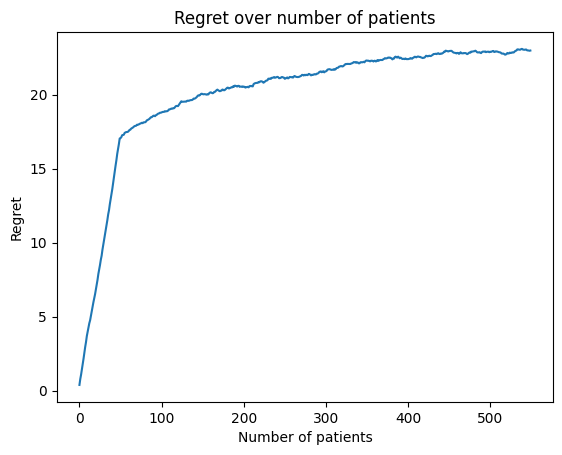

In [27]:
def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    mu_hat = []
    for result in results:
        successes = (result == 1).sum().item()
        failures = (result == 0).sum().item()
        a = successes + 1
        b = failures + 1
        sampled_value = np.random.beta(a, b)
        mu_hat.append(sampled_value)  
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):

    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs(mabs, n, m):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs(MABs, N, M)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()


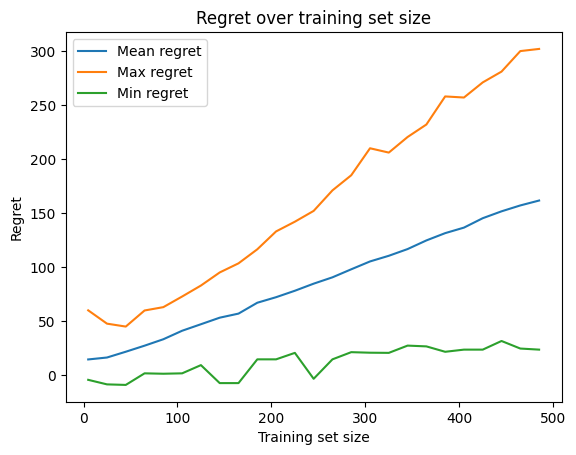

In [28]:
N_list = [i for i in range(K, M, 4*K)]

extracted_mean_regrets = []
extracted_max_regrets = []
extracted_min_regrets = []
for i in N_list:
    regrets = run_on_MABs(MABs, i, M + N - i)
    mean_regrets = torch.stack(regrets).mean(dim=0)
    mean_regrets_last = mean_regrets[-1]
    max_regrets_last = torch.stack(regrets).max(dim=0).values[-1]
    min_regrets_last = torch.stack(regrets).min(dim=0).values[-1]
    extracted_mean_regrets.append(mean_regrets_last)
    extracted_max_regrets.append(max_regrets_last)
    extracted_min_regrets.append(min_regrets_last)

plt.plot(N_list, extracted_mean_regrets, label='Mean regret')
plt.plot(N_list, extracted_max_regrets, label='Max regret')
plt.plot(N_list, extracted_min_regrets, label='Min regret')
plt.xlabel('Training set size')
plt.ylabel('Regret')
plt.title('Regret over training set size')
plt.legend()
plt.show()

*En faisant varier N entre K et M, on observe que la valeur optimale de N vis-à-vis de la minimisation du regret est 0. Ainsi, la méthode de Thompson ne nécéssite pas de phase d'exploration qui aurait même un impact négatif sur le regret.*

**Q13. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez le taux d'immunisation empirique  pour chaque vaccin avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

**Q14. Comparez le regret avec les autres algorithmes.**

Regret moyen:  20.234376907348633
Ecart type:  14.587598660093743


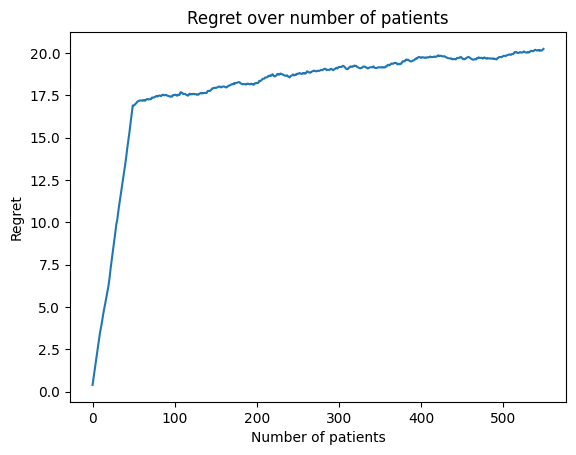

In [29]:
def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    return [result.mean() for result in results]

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):

    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Ici la méthode gloutonne avec une phase d'exploration N = 50, nous donne un regret de 20.23 avec un écart-type de 14.59.

Regret moyen:  48.614383697509766
Ecart type:  12.077563431924025


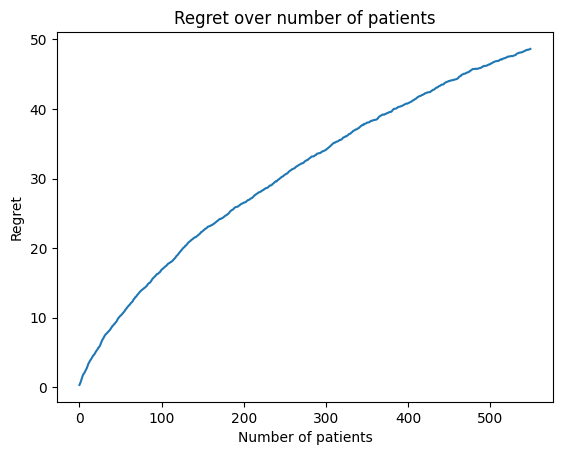

In [30]:
C = 2

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs(mabs, m):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs(MABs, M + N)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Avec la methode UCB avec C = 2, on obtient un regret et son écart-type de 48.61 et 12.08.*

Regret moyen:  13.734374046325684
Ecart type:  11.515886032065254


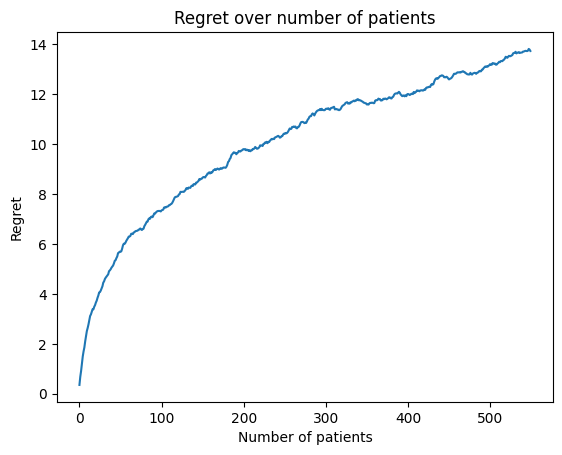

In [31]:
def calculate_mu_hat(results):
    mu_hat = []
    for result in results:
        successes = (result == 1).sum().item()
        failures = (result == 0).sum().item()
        a = successes + 1
        b = failures + 1
        sampled_value = np.random.beta(a, b)
        mu_hat.append(sampled_value)  
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs(mabs, m):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs(MABs, M + N)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*La méthode de Thompson donne les meilleurs résultats quand N = 0. Le regret et de 13.73 et son écart-type de 11.51 donc cette méthode est plus efficace et constante que UCB.*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

In [32]:
K = 100
N = 100
M = 550 - N
MABs = [generate_arms(K) for _ in range(100)]

Regret moyen:  86.7119369506836
Ecart type:  13.392874779099252


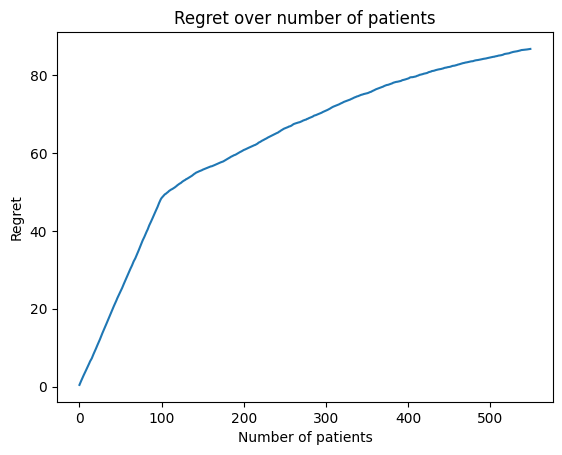

In [33]:
def explore(mab, n):
    test_per_arm = n // K
    results = []
    for arm in mab:
        results.append(arm.sample(test_per_arm).float())
    return results

def calculate_mu_hat(results):
    return [result.mean() for result in results]

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):

    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs_greedy(mabs, n, m):
    total_results = []
    for mab in mabs:
        results = explore(mab, n)
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs_greedy(MABs, N, M)
mean_regrets = torch.stack(regrets).mean(dim=0)


print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Pour la méthode gloutonne, le regret est bien plus élevé que précédemment mais l'écart-type ne semble pas impacté.*

Regret moyen:  214.0719757080078
Ecart type:  13.810146769987412


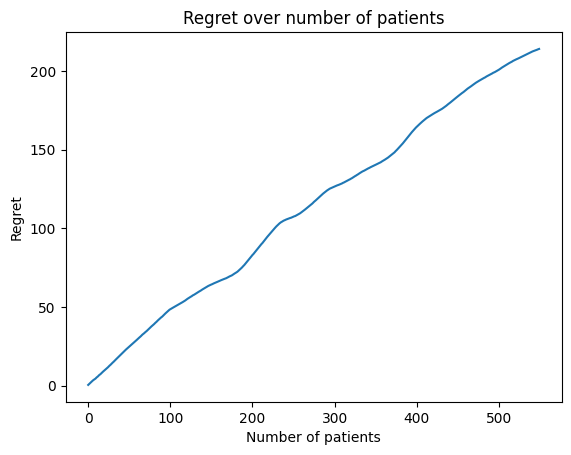

In [34]:
C = 2

def calculate_mu_hat(results):
    mu_hat = []
    total_patient = sum(len(result) for result in results)
    for result in results:
        if len(result) == 0:
            mu_hat.append(np.inf)
        else:
            mu_hat.append(result.mean() + math.sqrt(C * math.log(total_patient) / len(result)))
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs(mabs, m):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs(MABs, M + N)
mean_regrets = torch.stack(regrets).mean(dim=0)

print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*De la même façon pour la méthode UCB, le regret est aussi très élevé avec un écart-type peu impacté mais l'asymptote à droite est bien loin d'être horizontale.*

Regret moyen:  104.302001953125
Ecart type:  10.844713503551908


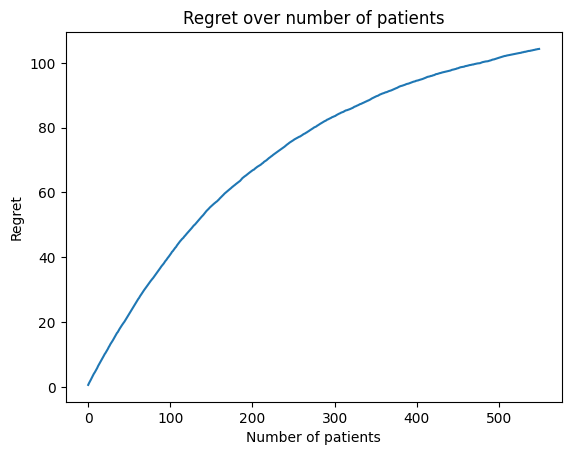

In [40]:
def calculate_mu_hat(results):
    mu_hat = []
    for result in results:
        successes = (result == 1).sum().item()
        failures = (result == 0).sum().item()
        a = successes + 1
        b = failures + 1
        sampled_value = np.random.beta(a, b)
        mu_hat.append(sampled_value)  
    return mu_hat

def search_best_arm(mu_hat):
    max_index = 0
    for i in range(1, len(mu_hat)):
        if mu_hat[i] > mu_hat[max_index]:
            max_index = i
    return max_index

def exploit(all_results, results, mab, mu_hat, m):
    for i in range(m):
        best_arm = search_best_arm(mu_hat)
        sample = mab[best_arm].sample().float()
        results[best_arm] = torch.cat([results[best_arm], sample])
        mu_hat = calculate_mu_hat(results)
        all_results = torch.cat([all_results, sample])
    return results, all_results

def run_on_MABs(mabs, m):
    total_results = []
    for mab in mabs:
        results = [torch.tensor([]) for _ in range(K)]
        all_results = torch.cat([results[i] for i in range(K)])
        mu_hat = calculate_mu_hat(results)
        results, all_results = exploit(all_results, results, mab, mu_hat, m)
        total_results.append(all_results)
    regrets = get_regret_list(mabs, total_results)
    return regrets

regrets = run_on_MABs(MABs, M + N)
mean_regrets = torch.stack(regrets).mean(dim=0)


print("Regret moyen: ", mean_regrets[-1].item())

ecart_type = math.sqrt(sum([(regrets[i][-1] - mean_regrets[-1].item())**2 for i in range(100)]) / 100)
print("Ecart type: ", ecart_type)


plt.plot(mean_regrets, label='Mean regret')
plt.xlabel('Number of patients')
plt.ylabel('Regret')
plt.title('Regret over number of patients')
plt.show()

*Pour la méthode de Thompson, c'est le même cas, regret élevé et écart-type faible.*

*Dans les trois cas, il y a bien trop de vaccins disponibles, ainsi il est difficile d'en extraire le meilleur vaccin, les données sont trop éparses comme la veut la malédiction de la dimension.*